## Plot quantum kernel
This script plots the shape of the quantum kernel as function of the features of the dataset.
Companion script to "Large-scale quantum machine learning" (https://arxiv.org/abs/2108.01039) by Tobias Haug, Chris N. Self and M.S. Kim.
The kernel can be generated by script and run on IBMQ, or one can load preprocessed data from https://doi.org/10.5281/zenodo.5211695.
This script studies the kernel of hardware efficient quantum circuits, which can be approximately described by weighted radial basis function kernels.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def error_mitigation(kernel_matrix):
    """
    Mitigate error of quantum kernel calculated via randomized measurements.
    Assumes depolarizing model.
    
    kernel_matrix: Quantum kernel as calculated by randomized measurements
    
    kernel_matrix_mitigated: Mitigated quantum kernel
    
    """
    dataset_size=np.shape(kernel_matrix)[0]
    kernel_matrix_mitigated=np.zeros([dataset_size,dataset_size])
    for rep in range(dataset_size):
        for rep2 in range(dataset_size):
            kernel_matrix_mitigated[rep,rep2]=kernel_matrix[rep,rep2]/np.sqrt(kernel_matrix[rep,rep]*kernel_matrix[rep2,rep2])
    return kernel_matrix_mitigated

def rbf_kernel(dataset,gamma=0.25):
    """
    classical radial basis function kernel between data1 and data2 exp(-gamma*(data1-data2)**2)
    
    dataset: Matrix containing features of dataset
    
    
    gram_matrix: resulting rbf kernel 
    """
    
    
    nData=len(dataset)
    gram_matrix=np.zeros([nData,nData])
    for i in range(nData):
        for j in range(nData):
            gram_matrix[i,j]=np.exp(-gamma*np.sum(np.abs(dataset[i]-dataset[j])**2))
    return gram_matrix


Load random-data kernel and feature vectors. This is used to calculate distribution of kernel as function of difference of feature vectors

In [3]:
main_path=os.path.join("studies","random-data","NPQC","results","processed","raw")

feature_file="X-ibmq_guadalupe,n_qubits8,depth8,n_shots8192,n_unitaries50,crossfid_modeRzRy,n_repeat100.csv"
kernel_file="GramMatrix-ibmq_guadalupe,n_qubits8,depth8,n_shots8192,n_unitaries50,crossfid_modeRzRy,n_repeat100.csv"

feature_data=np.loadtxt(os.path.join(main_path,feature_file),delimiter=",")
quantum_kernel_data=np.loadtxt(os.path.join(main_path,kernel_file),delimiter=",")

In [4]:
#unmitigated kernel
quantum_kernel_unmitigated=quantum_kernel_data

#mitigate quantum kernel
quantum_kernel_mitigated=error_mitigation(quantum_kernel_unmitigated)

#get classical rbf kernel as reference
rbf_kernel_data=rbf_kernel(feature_data)


dataset_size=np.shape(quantum_kernel_data)[0]


Calculate kernel as function of distance in feature vector space

In [5]:
upper_triu_indices=np.triu_indices(dataset_size,1)

bins_norm=21
bin_spacing_list=np.linspace(0,1,num=bins_norm+1)

#get mitigated kernel
quantum_kernel_mitigated_flat=quantum_kernel_mitigated[upper_triu_indices]


#get difference vector L2 norm in feature space X
difference_parameters_matrix=np.zeros([dataset_size,dataset_size])
for i in range(dataset_size):
    for j in range(dataset_size):
        difference_parameters_matrix[i,j]=np.sum(np.abs(feature_data[i]-feature_data[j])**2)
        
        
difference_parameters=difference_parameters_matrix[upper_triu_indices]


#make data ready for plotting
norm_max=20
bin_spacing_list=np.linspace(0,norm_max,num=bins_norm+1)

diff_parameters_range=np.linspace(0,np.amax(difference_parameters),num=51)
diff_parameters_range_plot=diff_parameters_range[diff_parameters_range<norm_max]




digitized_parameters=np.digitize(difference_parameters,bin_spacing_list)

norm_difference_parameters_binned = np.array([difference_parameters[digitized_parameters == i].mean() for i in range(1, len(bin_spacing_list))])


kernel_means = np.array([quantum_kernel_mitigated_flat[digitized_parameters == i].mean() for i in range(1, len(bin_spacing_list))])


kernel_std = np.array([quantum_kernel_mitigated_flat[digitized_parameters == i].std() for i in range(1, len(bin_spacing_list))])

fillbetween_fid=[norm_difference_parameters_binned,kernel_means+kernel_std,kernel_means-kernel_std,0.2]


    

Plot quantum kernel as function of difference between feature vectors. IBMQ data for the NPQC follows an approximate rbf kernel exp(-0.25*|x_i - x_j|^2)

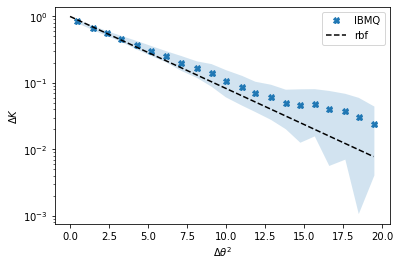

In [6]:
# plot fidelity as function of L2 norm of difference of feature vectors
plt.figure()
ax = plt.gca()
plt.plot(norm_difference_parameters_binned,kernel_means,marker="X",linestyle="")
ax.fill_between(fillbetween_fid[0], fillbetween_fid[1], fillbetween_fid[2], alpha=fillbetween_fid[3])
        

plt.plot(diff_parameters_range_plot,np.exp(-0.25*diff_parameters_range_plot),linestyle="--",marker="",color="black")
ax.set_yscale('log')
plt.legend(["IBMQ","rbf"])

plt.xlabel("$|x_i - x_j|^2$")
plt.ylabel("$\\Delta K$")
plt.show()